# Seed Clustering with K-Means

The goal is to group data in such a way that seeds in the same group/cluster are similar to each other and seeds in different clusters diverge

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import classification_report

In [10]:
header = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'length_g', 'type']
seeds = pd.read_csv('../root/input/seeds_dataset.txt', delimiter='\t+', names=header, engine='python')

In [ ]:
seeds.info()

In [ ]:
seeds.head()

In [ ]:
np.array(seeds.type)

In [ ]:
# Perform K-means clustering
km = KMeans(n_clusters=3, n_jobs=-1)
kmeans_pred = km.fit_predict(seeds.drop(['type'], axis=1))
kmeans_pred

In [15]:
# Update cluster labels
for i in range(len(kmeans_pred)):
    if kmeans_pred[i] == 2:
        kmeans_pred[i] = 1
    elif kmeans_pred[i] == 0:
        kmeans_pred[i] = 3
    elif kmeans_pred[i] == 1:
        kmeans_pred[i] = 2

In [ ]:
print('Accuracy of clustering is ' + '{}{}'.format(round(100 * sum(kmeans_pred == seeds.type) / len(seeds.type), 2), '%'))

In [ ]:
print(classification_report(seeds.type, kmeans_pred, target_names=['1', '2', '3'], digits=4))

## K-Means clustering with two variables

In [18]:
# Perform K-means clustering on a subset of features
seeds_small = seeds[['area', 'length']]
pred_small = km.fit_predict(seeds_small)

In [ ]:
seed_target = np.array(seeds.type)
seed_target

In [ ]:
pred_small

In [21]:
# Update target values for color iteration
for i in range(len(seed_target)):
    if seed_target[i] == 1:
        seed_target[i] = 2
    elif seed_target[i] == 3:
        seed_target[i] = 0
    else:
        seed_target[i] = 1

Text(0.5, 1.0, 'Predictions')

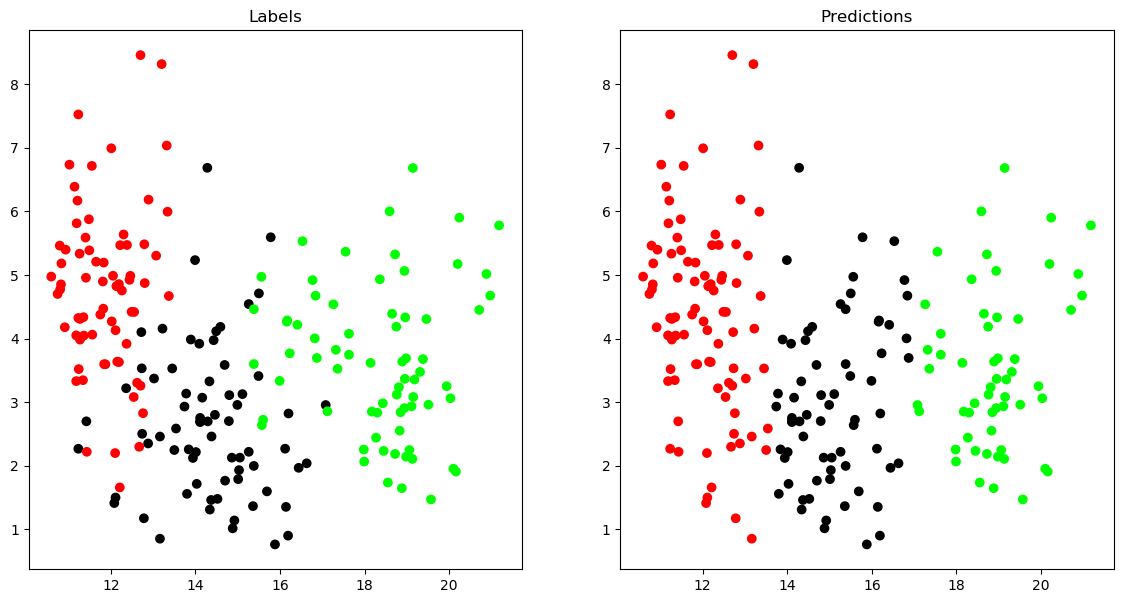

In [22]:
# Create a scatter plot to visualize the labels and predictions
plt.figure(figsize=(14, 7))
 
colormap = np.array(['red', 'lime', 'black'])
 
plt.subplot(1, 2, 1)
plt.scatter(seeds.area, seeds.asymmetry, c=colormap[seed_target])
plt.title('Labels')
 
plt.subplot(1, 2, 2)
plt.scatter(seeds.area, seeds.asymmetry, c=colormap[pred_small])
plt.title('Predictions')

In [23]:
print('Accuracy of clustering is ' + '{}{}'.format(round(100*sum(pred_small == seed_target) / len(seed_target), 2), '%'))

Accuracy of clustering is 84.29%


## Manual Implementation of KMeans

In [24]:
X = np.array(seeds[['area', 'asymmetry']])

In [25]:
# Define the initial centroids for K-means clustering
first_centroids = np.array([[12, 4], [18, 5], [19, 3]])

In [26]:
# Visualizing the data and clustering results
def clus_col(X, centroids, preds):
    """
    Function to assign colors to clusters.
    """
    for x in range(centroids[0].shape[0]):
        yield (np.array([X[i] for i in range(X.shape[0]) if preds[i] == x]))

def draw_hist(h, centroids):
    """
    Data for plotting history
    """
    for centroid in centroids:
        yield (centroid[:,h])
            
            
def plot_clust(X, centroids, preds=None):
    # Number of colors should be equal to the number of clusters, so add more if necessary.
    colors = ['green', 'fuchsia', 'tan']
    
    # If clusters are defined (preds != None), colors are assigned to clusters.
    clust = [X] if preds is None else list(clus_col(X, centroids, preds))
    
    # Plot clusters
    fig = plt.figure(figsize=(7, 5))
    for i in range(len(clust)):
        plt.plot(clust[i][:,0], clust[i][:,1], 'o', color=colors[i], alpha=0.75, label='Cluster %d'%i)
    plt.xlabel('area')
    plt.ylabel('asymmetry')

    # Plot history of centroids.
    tempx = list(draw_hist(0, centroids))
    tempy = list(draw_hist(1, centroids))
    
    for x in range(len(tempx[0])):
        plt.plot(tempx, tempy, 'ro--', markersize=6)

    leg = plt.legend(loc=4)

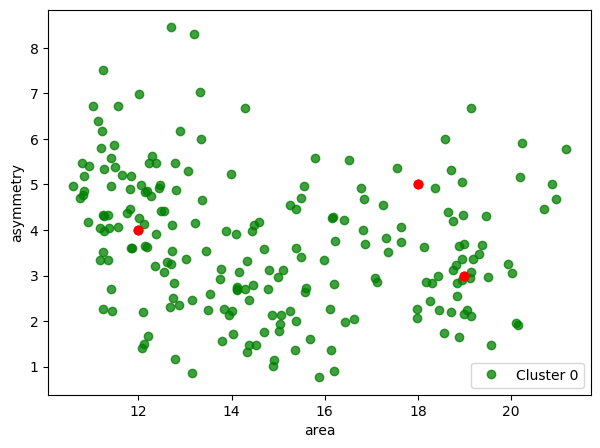

In [ ]:
# Scatterplot with initial centroids.
plot_clust(X,[first_centroids])

In [28]:
def find_centroids(X, centroids):
    """
    Function to assign data points to the nearest centroids.
    """
    preds = np.zeros((X.shape[0], 1))
    for j in range(preds.shape[0]):

        dist, label = 9999999, 0
        for i in range(centroids.shape[0]):
            distsquared = np.sum(np.square(X[j] - centroids[i]))
            if distsquared < dist:
                dist = distsquared
                label = i

        preds[j] = label
        
    return preds

In [29]:
def calc_centroids(X, preds):
    """
    Function to calculate new centroids based on the assigned data points.
    """
    for x in range(len(np.unique(preds))):
        yield np.mean((np.array([X[i] for i in range(X.shape[0]) if preds[i] == x])), axis=0)

In [30]:
def iters(X, first_centroids, K, n_iter):
    """
    Perform K-means iterations to find the final centroids and cluster assignments.
    """
    centroid_history = []
    current_centroids = first_centroids
    for iter in range(n_iter):
        centroid_history.append(current_centroids)
        preds = find_centroids(X, current_centroids)
        current_centroids = np.array(list(calc_centroids(X, preds)))
    return preds, centroid_history

In [31]:
preds, centroid_history = iters(X, first_centroids, 3, 20)

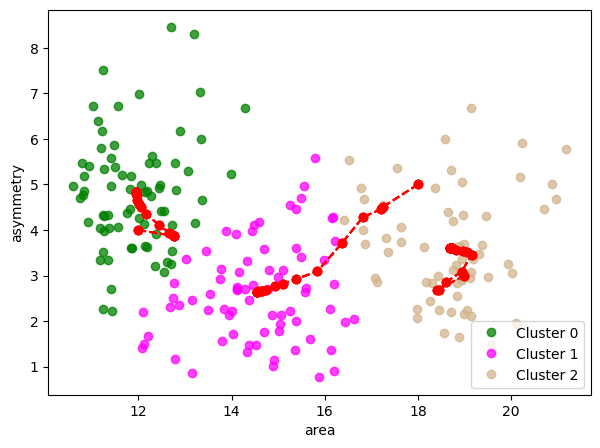

In [32]:
plot_clust(X,centroid_history,preds)

In [33]:
first_centroids = np.array([[12, 13, 0.85, 6, 2, 4, 4], [18, 15, 0.9, 6, 3, 5, 5], [19, 14, 0.9, 5.8, 2, 3, 6]])
X = np.array(seeds.drop(['type'], axis=1))

In [34]:
preds, centroid_history = iters(X,first_centroids,K=3,n_iter=20)

In [43]:
# Reshaping into 1-D array.
r = np.reshape(preds, (210,))
r

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1.,
       2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [44]:
# Update cluster labels
for i in range(len(r)):
    if r[i] == 0:
        r[i] = 3

In [45]:
sum(r == seeds.type) / len(seeds.type)

0.8904761904761904

## Voronoi Diagram



In [46]:
# Perform PCA to reduce dimensionality to 2
reduced_data = PCA(n_components=2).fit_transform(seeds.drop(['type'], axis=1))

# Initialize KMeans clustering with 3 clusters using k-means++ initialization
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)

# Fit the KMeans model to the reduced data
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

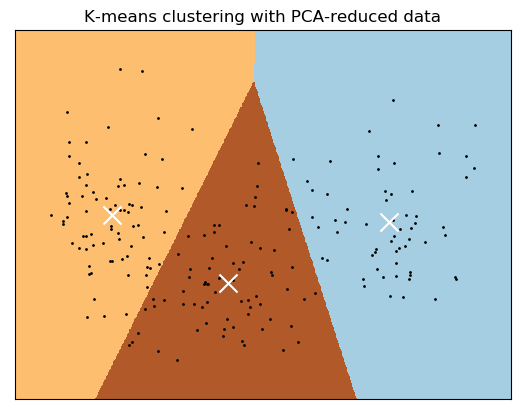

In [47]:
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Obtain labels for each point in mesh
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Put the result into a color plot
plt.figure(1)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering with PCA-reduced data')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## High-dimensional data visualization

In [48]:
seeds_little = pd.concat([seeds[50:60],seeds[70:80],seeds[140:150]])

In [49]:
def scatter6d(x, y, z, color, colorsMap='summer'):
    """
    Function to create a 3D scatter plot with colors representing a variable using a colormap.
    
    Parameters:
        x (array-like): X coordinates of the data points.
        y (array-like): Y coordinates of the data points.
        z (array-like): Z coordinates of the data points.
        color (array-like): Color values for each data point.
        colorsMap (str, optional): Name of the colormap to use. Default is 'summer'.
    """
    cNorm = matplotlib.colors.Normalize(vmin=min(color), vmax=max(color))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap(colorsMap))
    fig = plt.figure()
    ax = Axes3D(fig)
    markers = ['s', 's', 'o', '^']
    for i in seeds.type.unique():
        ax.scatter(x, y, z, c=scalarMap.to_rgba(color), marker=markers[i], s=seeds_little.asymmetry * 50)
    scalarMap.set_array(color)
    fig.colorbar(scalarMap, label='{}'.format('length'))
    plt.show()

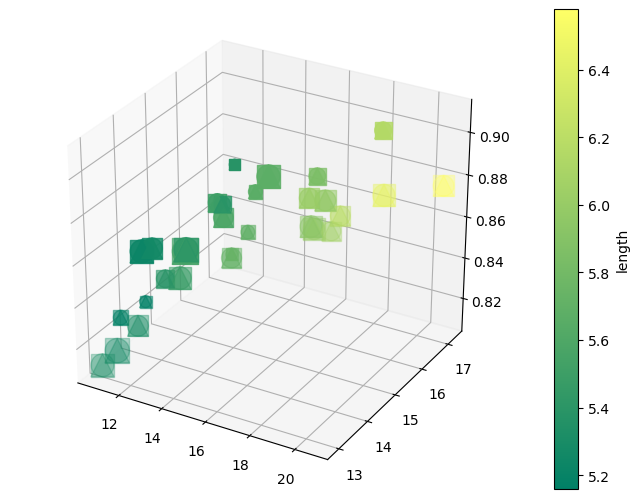

In [50]:
scatter6d(seeds_little.area, seeds_little.perimeter, seeds_little.compactness, seeds_little.length)